In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
import modules.io as io

In [2]:
DATA_KEY    = "VAL"
CONFIG_FILE = "../config/resnet.yaml"
#CONFIG_FILE = "../config/i2i_regression.yaml"

LOAD = True

config      = io.load_yaml(CONFIG_FILE)
config['MODEL_DIR'] = config['MODEL_DIR'].replace('.','..')

In [3]:
import factories.dataset_factory as dataset_factory

data    = dataset_factory.get(config, DATA_KEY)

239it [00:00, 3676.57it/s]
  2%|▏         | 5/239 [00:00<00:04, 47.03it/s]

centering images


100%|██████████| 239/239 [00:02<00:00, 91.06it/s]


In [4]:
import factories.model_factory as model_factory

model = model_factory.get(config)
if LOAD: model.load()

/home/marsdenlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[None, 819200]
INFO:tensorflow:Restoring parameters from ../results/ResNetReg/model/ResNetReg


In [5]:
import factories.preprocessor_factory as prepro_factory

preprocessor = prepro_factory.get(config)

In [6]:
import numpy as np
X = 0.1*np.array([preprocessor(x) for x in data[0]])
print(X.shape)

(239, 160, 160, 1)


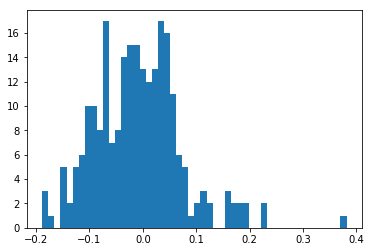

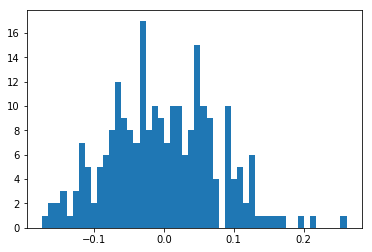

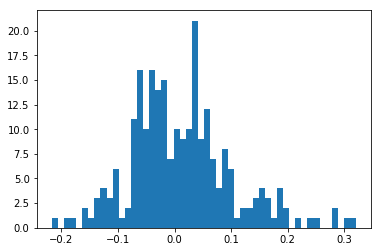

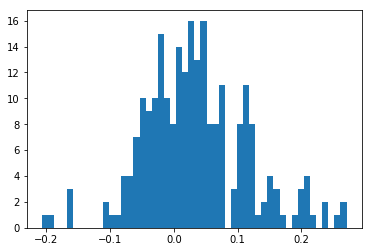

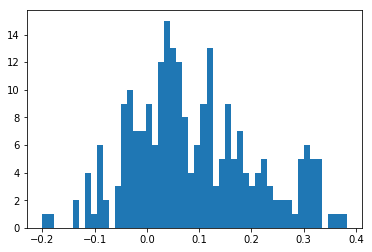

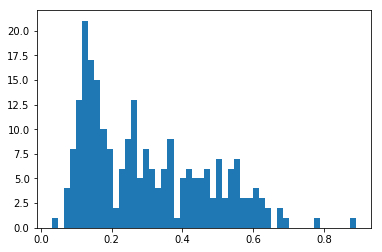

In [7]:
import matplotlib.pyplot as plt

mid = int(X.shape[1]/2)
xl = [-3,8]

plt.figure()
plt.hist(X[:,0,0,0],bins=50)
#plt.xlim(xl)
plt.show()

plt.figure()
plt.hist(X[:,20,20,0],bins=50)
#plt.xlim(xl)
plt.show()

plt.figure()
plt.hist(X[:,40,40,0],bins=50)
#plt.xlim(xl)
plt.show()

plt.figure()
plt.hist(X[:,60,60,0],bins=50)
#plt.xlim(xl)
plt.show()

plt.figure()
plt.hist(X[:,70,70,0],bins=50)
#plt.xlim(xl)
plt.show()

plt.figure()
plt.hist(X[:,mid,mid,0],bins=50)
#plt.xlim(xl)
plt.show()

In [8]:
import tensorflow as tf

In [9]:
tensor_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
for t in tensor_list:
    print(t)

Placeholder
Placeholder_1
resnet/resblock_before/projection/random_normal/shape
resnet/resblock_before/projection/random_normal/mean
resnet/resblock_before/projection/random_normal/stddev
resnet/resblock_before/projection/random_normal/RandomStandardNormal
resnet/resblock_before/projection/random_normal/mul
resnet/resblock_before/projection/random_normal
resnet/resblock_before/projection/W
resnet/resblock_before/projection/W/Assign
resnet/resblock_before/projection/W/read
resnet/resblock_before/projection/zeros
resnet/resblock_before/projection/b
resnet/resblock_before/projection/b/Assign
resnet/resblock_before/projection/b/read
resnet/resblock_before/projection/convolution/dilation_rate
resnet/resblock_before/projection/convolution
resnet/resblock_before/projection/add
resnet/resblock_before/projection/Identity
resnet/resblock_before/res_0/conv_1/random_normal/shape
resnet/resblock_before/res_0/conv_1/random_normal/mean
resnet/resblock_before/res_0/conv_1/random_normal/stddev
resnet/r

In [10]:
#############################
# ResNet
#############################
N=2
#convs = ['conv_1', 'conv_2', 'conv_3']
convs = ['conv_3']
ops_before = []
for i in range(N):
    for c in convs:
        s = 'resnet/resblock_before/res_{}/{}/add:0'.format(i,c)
        
        op = tf.get_default_graph().get_tensor_by_name(s)
        ops_before.append(op)
        
ops_after = []
for i in range(N):
    for c in convs:
        s = 'resnet/resblock_after/res_{}/{}/add:0'.format(i,c)
        
        op = tf.get_default_graph().get_tensor_by_name(s)
        ops_after.append(op)
        
ops = ops_before+ops_after

In [11]:
#############################
# I2INet
#############################
# names = [
#     "block1/conv2d/add:0",
#     "block1/conv2d_1/add:0",
#     "block2/conv2d/add:0",
#     "block2/conv2d_1/add:0",
#     "block3/conv2d/add:0",
#     "block3/conv2d_1/add:0",
#     "block4/conv2d/add:0",
#     "block4/conv2d_1/add:0",
#     "ublock1/conv2d/add:0",
#     "ublock1/conv2d_1/add:0",
#     "ublock1/conv2d_2/add:0",
#     "ublock2/conv2d/add:0",
#     "ublock2/conv2d_1/add:0",
#     "ublock2/conv2d_2/add:0",
#     "ublock3/conv2d/add:0",
#     "ublock3/conv2d_1/add:0",
#     "ublock3/conv2d_2/add:0",
#     "conv2d/add:0"    
# ]

# ops = []

# for n in names:      
#     op = tf.get_default_graph().get_tensor_by_name(n)
#     ops.append(op)

In [12]:
nb = 8
xb = X[:nb,:,:]
outs = []
for op in ops:
    out = model.sess.run(op,{model.x:xb})
    print(out.shape)
    outs.append(out)

(8, 160, 160, 32)
(8, 160, 160, 32)
(8, 160, 160, 32)
(8, 160, 160, 32)


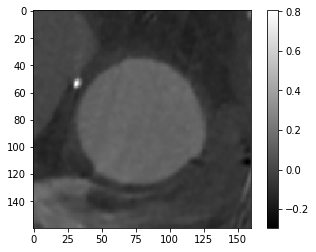

0


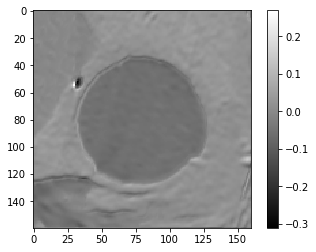

1


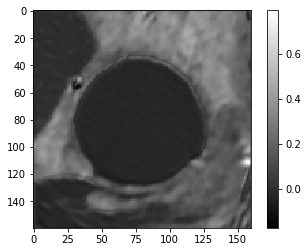

2


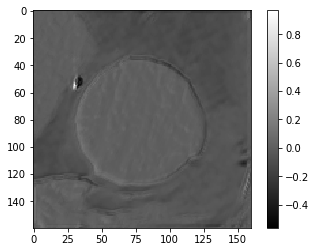

3


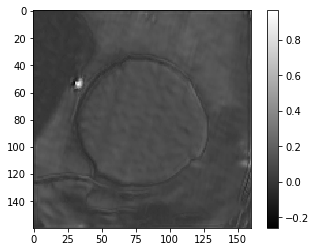

In [13]:
plt.figure()
plt.imshow(xb[0,:,:,0], cmap='gray')
plt.colorbar()
plt.show()

for i,o in enumerate(outs):
    k = np.random.randint(o.shape[3])
    y = o[0,:,:,k]
    
    print(i)
    plt.figure()
    plt.imshow(y, cmap='gray')
    plt.colorbar()
    plt.show()

In [15]:
s = 'fc_final/add:0'
op = tf.get_default_graph().get_tensor_by_name(s)
yhat = model.sess.run(op,{model.x:xb})

for y in yhat:
    print(y)

[ 0.02725714  0.02190885  0.00220083  0.02557394 -0.02972889  0.05393688
  0.05223728 -0.01257362  0.02233404  0.06950126  0.01826458  0.05347554
  0.03747572  0.04037122  0.02005514]
[-0.10014153 -0.10867292 -0.06101844 -0.04890369 -0.01727057  0.0511006
  0.02513389  0.05310846  0.0559991   0.0464483  -0.0073046  -0.01089629
 -0.07491575 -0.06422042 -0.12629318]
[ 0.00976403 -0.07703014  0.01248864 -0.00916041 -0.01224224  0.01624017
  0.01367728 -0.00341647 -0.01705085  0.00976761  0.01329489  0.02534283
 -0.04328512  0.02317512 -0.01753415]
[ 0.01124208 -0.05353921  0.03070125 -0.00719856 -0.02336855  0.00374349
 -0.03537821 -0.03696195 -0.06094098 -0.05059313 -0.04185944 -0.03206077
 -0.07756085  0.00102066 -0.03687333]
[-0.03200255 -0.08538288 -0.01279575 -0.03810827 -0.04358034 -0.01791133
 -0.00893713 -0.04618559 -0.02684896 -0.0241927  -0.02440664 -0.01795025
 -0.06718125 -0.01030145 -0.00679808]
[-0.06822944 -0.09318327 -0.04521003 -0.06288017 -0.06412468 -0.01536618
 -0.0198